In [36]:
# Adopted from Quantopian
# Code updated for python 3
# cvxopt adopted for proper versioning

In [264]:
# Required python package imports
import sqlalchemy
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pylab as pylab
import time 
import multiprocessing 
%matplotlib inline
import datetime
from yahoo_finance import Share
import cvxopt as opt
from cvxopt import blas, solvers
params = {'legend.fontsize': 'x-large','figure.figsize': (15, 5),'axes.labelsize': 'x-large','axes.titlesize':'x-large',
         'xtick.labelsize':'x-large','ytick.labelsize':'x-large','axes.facecolor': 'white'}
pylab.rcParams.update(params)
np.random.seed(123)
solvers.options['show_progress'] = False

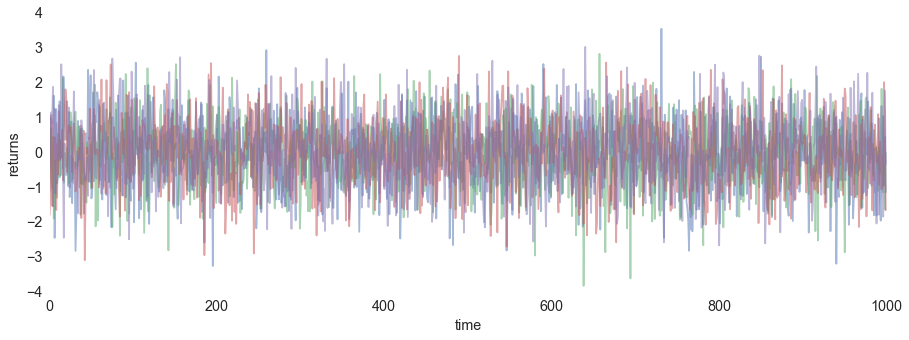

In [265]:
## Number of assets, observations
n_assets, n_obs = 4, 1000
return_vec = np.random.randn(n_assets, n_obs)

plt.plot(return_vec.T, alpha=0.5);
plt.xlabel('time')
plt.ylabel('returns') 

In [266]:
# Produces n random weights that sum to 1 
def rand_weights(n):
    k = np.random.rand(n)
    return k / sum(k)
print (rand_weights(n_assets))
print (rand_weights(n_assets))

[ 0.54066805  0.2360283   0.11660484  0.1066988 ]
[ 0.27638339  0.03006307  0.47850085  0.21505269]


In [267]:
#  Returns the mean and standard deviation of returns for a random portfolio
def random_portfolio(returns):
    p = np.asmatrix(np.mean(returns, axis=1))
    w = np.asmatrix(rand_weights(returns.shape[0]))
    C = np.asmatrix(np.cov(returns))
    mu = w * p.T
    sigma = np.sqrt(w * C * w.T)    
    # This recursion reduces outliers to keep plots pretty
    if sigma > 2:
        return random_portfolio(returns) #if sigma is bigger than 2, then
    return mu, sigma

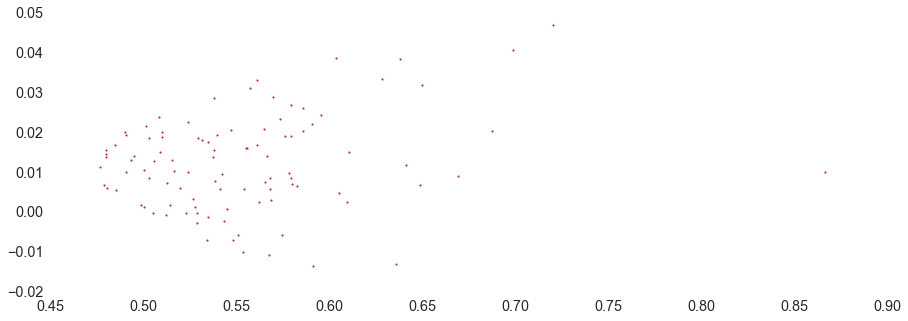

In [273]:
n_portfolios = 100
means, stds = np.column_stack([random_portfolio(return_vec) for _ in range(n_portfolios)])
plt.plot(stds, means,'ro', markersize=2)

In [274]:
def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    N = 1000
    mus = [10**(5 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks, np.asarray(pbar), np.asmatrix(S)

[[  3.62288366e-09]
 [  4.64831081e-06]
 [  2.08925977e-06]
 [  9.99993259e-01]]
[[ 0.0664783]]
[[ 0.97917506]]


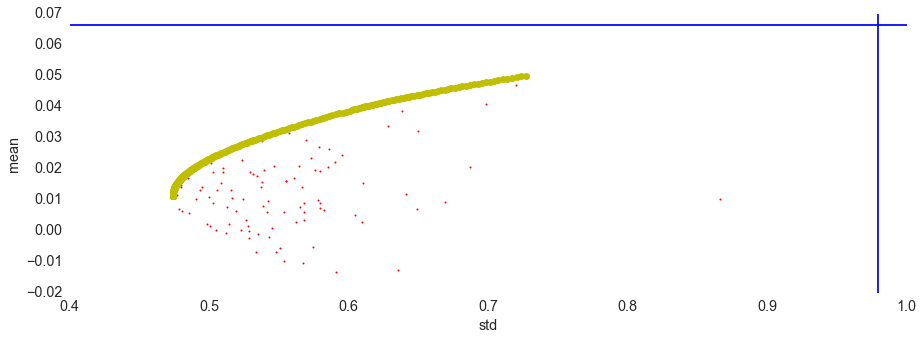

In [275]:
weights, returns, risks, pbar, S = optimal_portfolio(return_vec)
p_ret = weights.T.dot(pbar)
p_std = weights.T.dot(S).dot(weights)

plt.plot(stds, means, 'ro', markersize=2)
plt.ylabel('mean')
plt.xlabel('std')
plt.plot(risks, returns, 'y-o')
plt.axhline(y=p_ret)
plt.axvline(x=p_std)
print(weights)
print(p_ret)
print(p_std)